<a href="https://colab.research.google.com/github/jayoung977/DM2020/blob/master/ML_KAGGLE_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 가져오기


pip install --upgrade kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
!ls

drive  gender_submission.csv  sample_data  submission.csv  test.csv  train.csv


In [4]:
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/ML-KAGGLE/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle -v

Kaggle API 1.5.4


In [6]:
! kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started      Kudos        178           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2966           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      22506            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5033           False  
connectx                                       2030-01-01 00:00:00  Getting Started  Knowledge        710           False  
nlp-getting-started                            2030-01-01 00:00:00  Getting Started      Kudos       1479           False  
competit

In [7]:
!kaggle competitions download -c titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


#2. 문제 정의하기

##1) 목적?
 - 탑승자의 생존여부: 훈련 데이터에 레이블이 포함됨(사망,생존 두가지이므로 binary)
 - 분류 즉 지도학습 알고리즘을 사용할 수 있음

##2) 지도 학습 알고리즘(40p)
 - k-Nearest Neighbor (kNN)
 - Linear Regression
 - Logistic Regression
 - Support Vector Machine (SVM)
 - Decision Tree
 - Random Forest
 - Neural networks

##3) 앙상블 기법
 - 일련의 예측기로부터 예측을 수집하여 더 좋은 예측을 얻음
 - 종류: 
#####1) Bagging - Randomforest
#####2) Pasting  
#####3) Boosting - AdaBoost, Gradient Boost
#####4) Stacking 
    


**따라서, 보다 더 좋은 예측을 내기 위해서 앙상블 기법을 사용하기로 결정함**

그중에서도 Boosting 에서 **아다 부스트(ADA Boost)** 를 이용하여 
예측할 것임

**이유**는 Bagging과 Pasting은 같은 알고리즘을 사용하면서 훈련서브셋을 무작위로 구성하여 학습하지만 Boosting은 약한 학습기를 여러개 연결하여 강한학습기를 만들어준다. 즉 보완을 해주고 특히 아다부스트는 순차적으로 가중치를 조정하여 모형의 정확도를 향상시켜주므로 **Boosting이 Bagging더 보다 정확도가 높을 것으로 예측했기 때문이다.**
Stacking으로 하지 않은 이유는
기본적으로 과적합의 문제점이 있고 이미 캐글에 8줄의 코드만 치면 완성되기에 배우는 과정이 없다고 생각했기 때문이다.



#3. 데이터 구조 흝어보기`
-pandas,numpy,seaborn

-head(), info(), vaiu_count()


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline      
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score #분류 성능 평가
from sklearn.model_selection import train_test_split # train : test = 12 : 2 (문제 조건)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
train_set = pd.read_csv('/content/train.csv')
test_set = pd.read_csv('/content/test.csv')

In [10]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_set.head()    #

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
train_set.shape

(891, 12)

In [13]:
test_set.shape # 12인데 11열인 이유는 생존결과가 빠졌기 때문임

(418, 11)

### Null값 확인 및 sample 수 확인

In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### NULL데이터 시각화
[출처](https://kaggle-kr.tistory.com/17)




In [15]:
for col in test_set.columns:
    msg = 'column: {:>10}\t Percent of NaN value:ㅡ {:.2f}%'.format(col, 100 * (test_set[col].isnull().sum() / test_set[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value:ㅡ 0.00%
column:     Pclass	 Percent of NaN value:ㅡ 0.00%
column:       Name	 Percent of NaN value:ㅡ 0.00%
column:        Sex	 Percent of NaN value:ㅡ 0.00%
column:        Age	 Percent of NaN value:ㅡ 20.57%
column:      SibSp	 Percent of NaN value:ㅡ 0.00%
column:      Parch	 Percent of NaN value:ㅡ 0.00%
column:     Ticket	 Percent of NaN value:ㅡ 0.00%
column:       Fare	 Percent of NaN value:ㅡ 0.24%
column:      Cabin	 Percent of NaN value:ㅡ 78.23%
column:   Embarked	 Percent of NaN value:ㅡ 0.00%


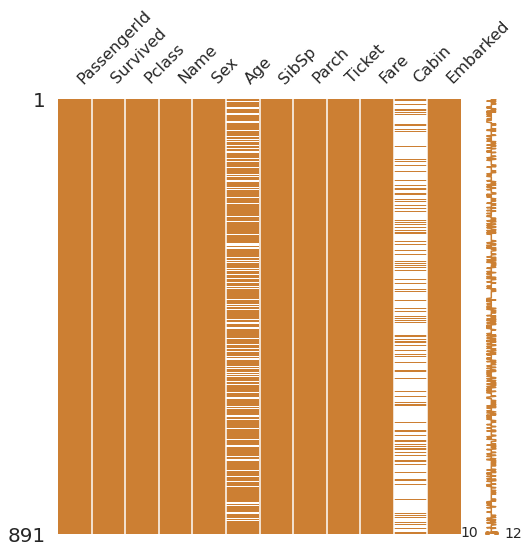

In [16]:
plt.style.use('seaborn')
sns.set(font_scale=2.5)  
                          #matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
msno.matrix(df=train_set.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

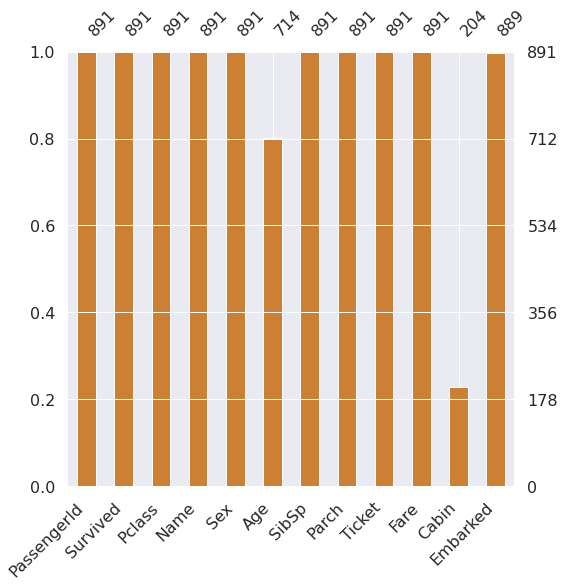

In [17]:
msno.bar(df=train_set.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

* **Age Cabin,Eabarked**에서 Null값 존재하므로 **채워줘야함**
* **Cabin** 값은 상당히 많은 누락을 가지고 있으므로 추정에 이용하지 않기로함-열삭제

### 각 속성 이해
* survived : 생존=1, 죽음=0
*pclass : 승객 등급. 1등급=1, 2등급=2, 3등급=3
*sibsp : 함께 탑승한 형제 또는 배우자 수
*parch : 함께 탑승한 부모 또는 자녀 수
*ticket : 티켓 번호
*cabin : 선실 번호
*embarked : 탑승장소 S=Southhampton, C=Cherbourg, Q=Queenstown
 (출처: https://jfun.tistory.com/136?category=828812)


###categorical data를 value_counts()로 확인

In [18]:
train_set["Name"].value_counts()

Mannion, Miss. Margareth             1
Smith, Mr. Richard William           1
Uruchurtu, Don. Manuel E             1
Harper, Miss. Annie Jessie "Nina"    1
Navratil, Master. Edmond Roger       1
                                    ..
Renouf, Mr. Peter Henry              1
Sivic, Mr. Husein                    1
Pavlovic, Mr. Stefo                  1
Rice, Master. George Hugh            1
Kink, Mr. Vincenz                    1
Name: Name, Length: 891, dtype: int64

* **이름**은 예측하기로도 생존에 영향을 안줄 것으로 판단됨

In [19]:
train_set["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [20]:
train_set["Ticket"].value_counts()

CA. 2343           7
347082             7
1601               7
347088             6
3101295            6
                  ..
S.C./A.4. 23567    1
345781             1
234686             1
345770             1
3101276            1
Name: Ticket, Length: 681, dtype: int64

* **Ticket**값은 이름이 다 다르기 때문에 사용하려면 처리가 필요해보임

In [21]:
train_set["Cabin"].value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
F2             3
C22 C26        3
              ..
D49            1
A32            1
D19            1
A36            1
C118           1
Name: Cabin, Length: 147, dtype: int64

In [22]:
train_set["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

###숫자형 특성 요약정보확인
####(1) .describe()
####(2) .hist() ;히스토그램 

In [23]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


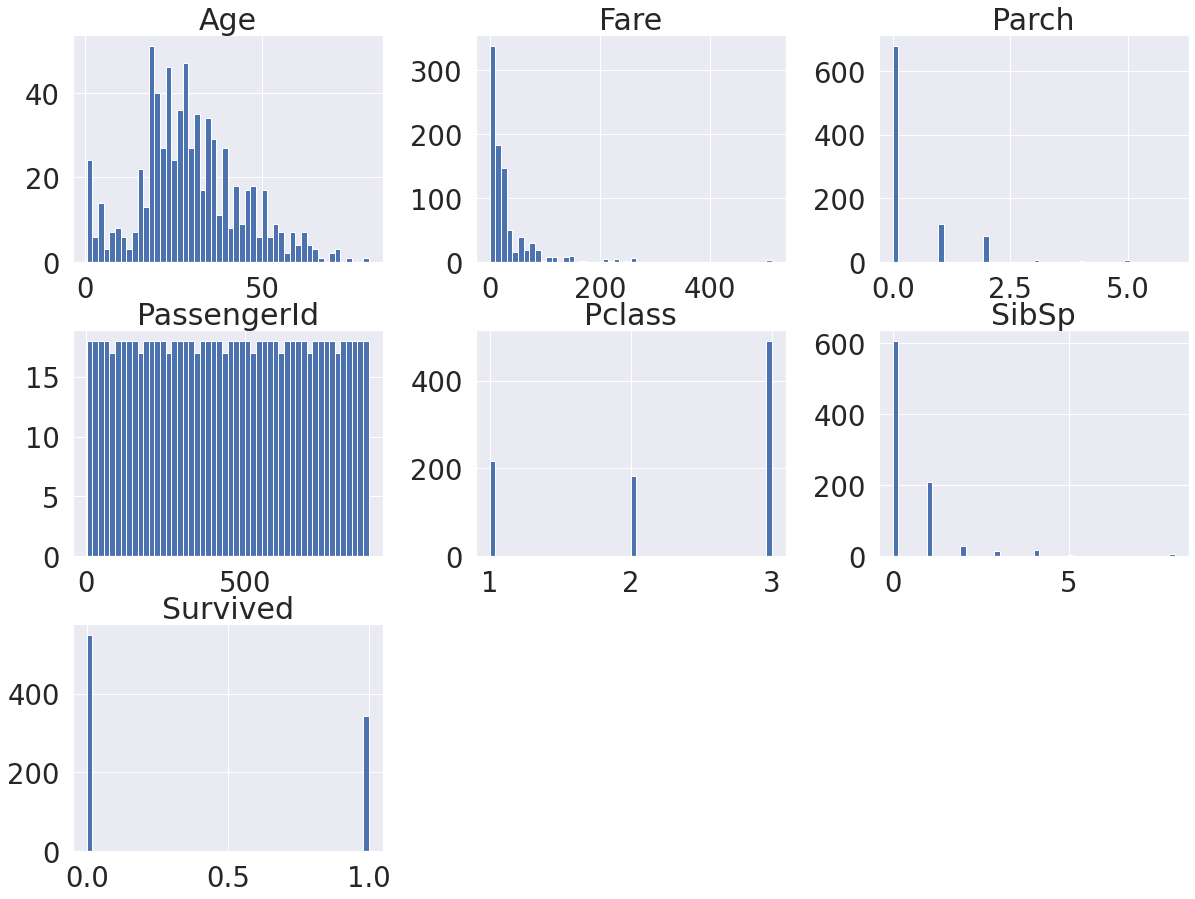

In [24]:
train_set.hist(bins=50, figsize=(20,15))
plt.show()

In [25]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

###훈련세트 손상시키지 않기 위해 복사본 만들기
- .copy()

In [26]:
train_copy = train_set.copy()

### 상관관계 조사 (94p)
####(1) .corr() 
 
 ;데이터 셋이 891로 작아서 쉽게 계산 가능


In [27]:
corr_matrix = train_copy.corr()

In [28]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

* 범주형 데이터는 빠져있음 따라서 완전한 상관관계 분석을 위해서는 **숫자형**으로 인코딩해줘야함
* 전처리 이후 다시 파악할 것임

* |1| 에 가까울 수록 상관관계가 크고 0에 가까울 수록 상관관계가 작음 
: 따라서

  > Pclass > Fare > Parch > Age > SibSp >> PassengerID(영향 없음)
 
     순으로 상관관계 있음을 예측할 수 있음 
     ****

####(2).scatter_matrix() ; 산점도 
* 상관관계 파악
(2단원에 나온 내용)
([출처](https://www.kaggle.com/redenventeria/just-another-titanic-kernel-fork))

In [29]:
train_filtered = train_copy

In [30]:
# Cabin: NaN=0, Other=1 으로 숫자형으로 만들어줌
train_filtered['Cabin'] = np.where(train_filtered['Cabin'].isnull(), 0,1)

# Embarked: C == 0, Q =  1, S  = 2 으로 숫자형으로 만들어줌

train_filtered['Embarked'] = np.where(train_filtered['Embarked']=='C', 0, np.where(train_filtered['Embarked']=='Q',1,2))

# Sex: male=0, female=1

train_filtered['Sex'] = np.where(train_filtered['Sex']=='male', 0, 1)

# Ticket: Single=0, Family=1 -이름이 중복이면 가족인 것으로 간주함

train_filtered.Ticket = np.where(train_filtered.Ticket.duplicated(), 1,0)

[102]

[102]

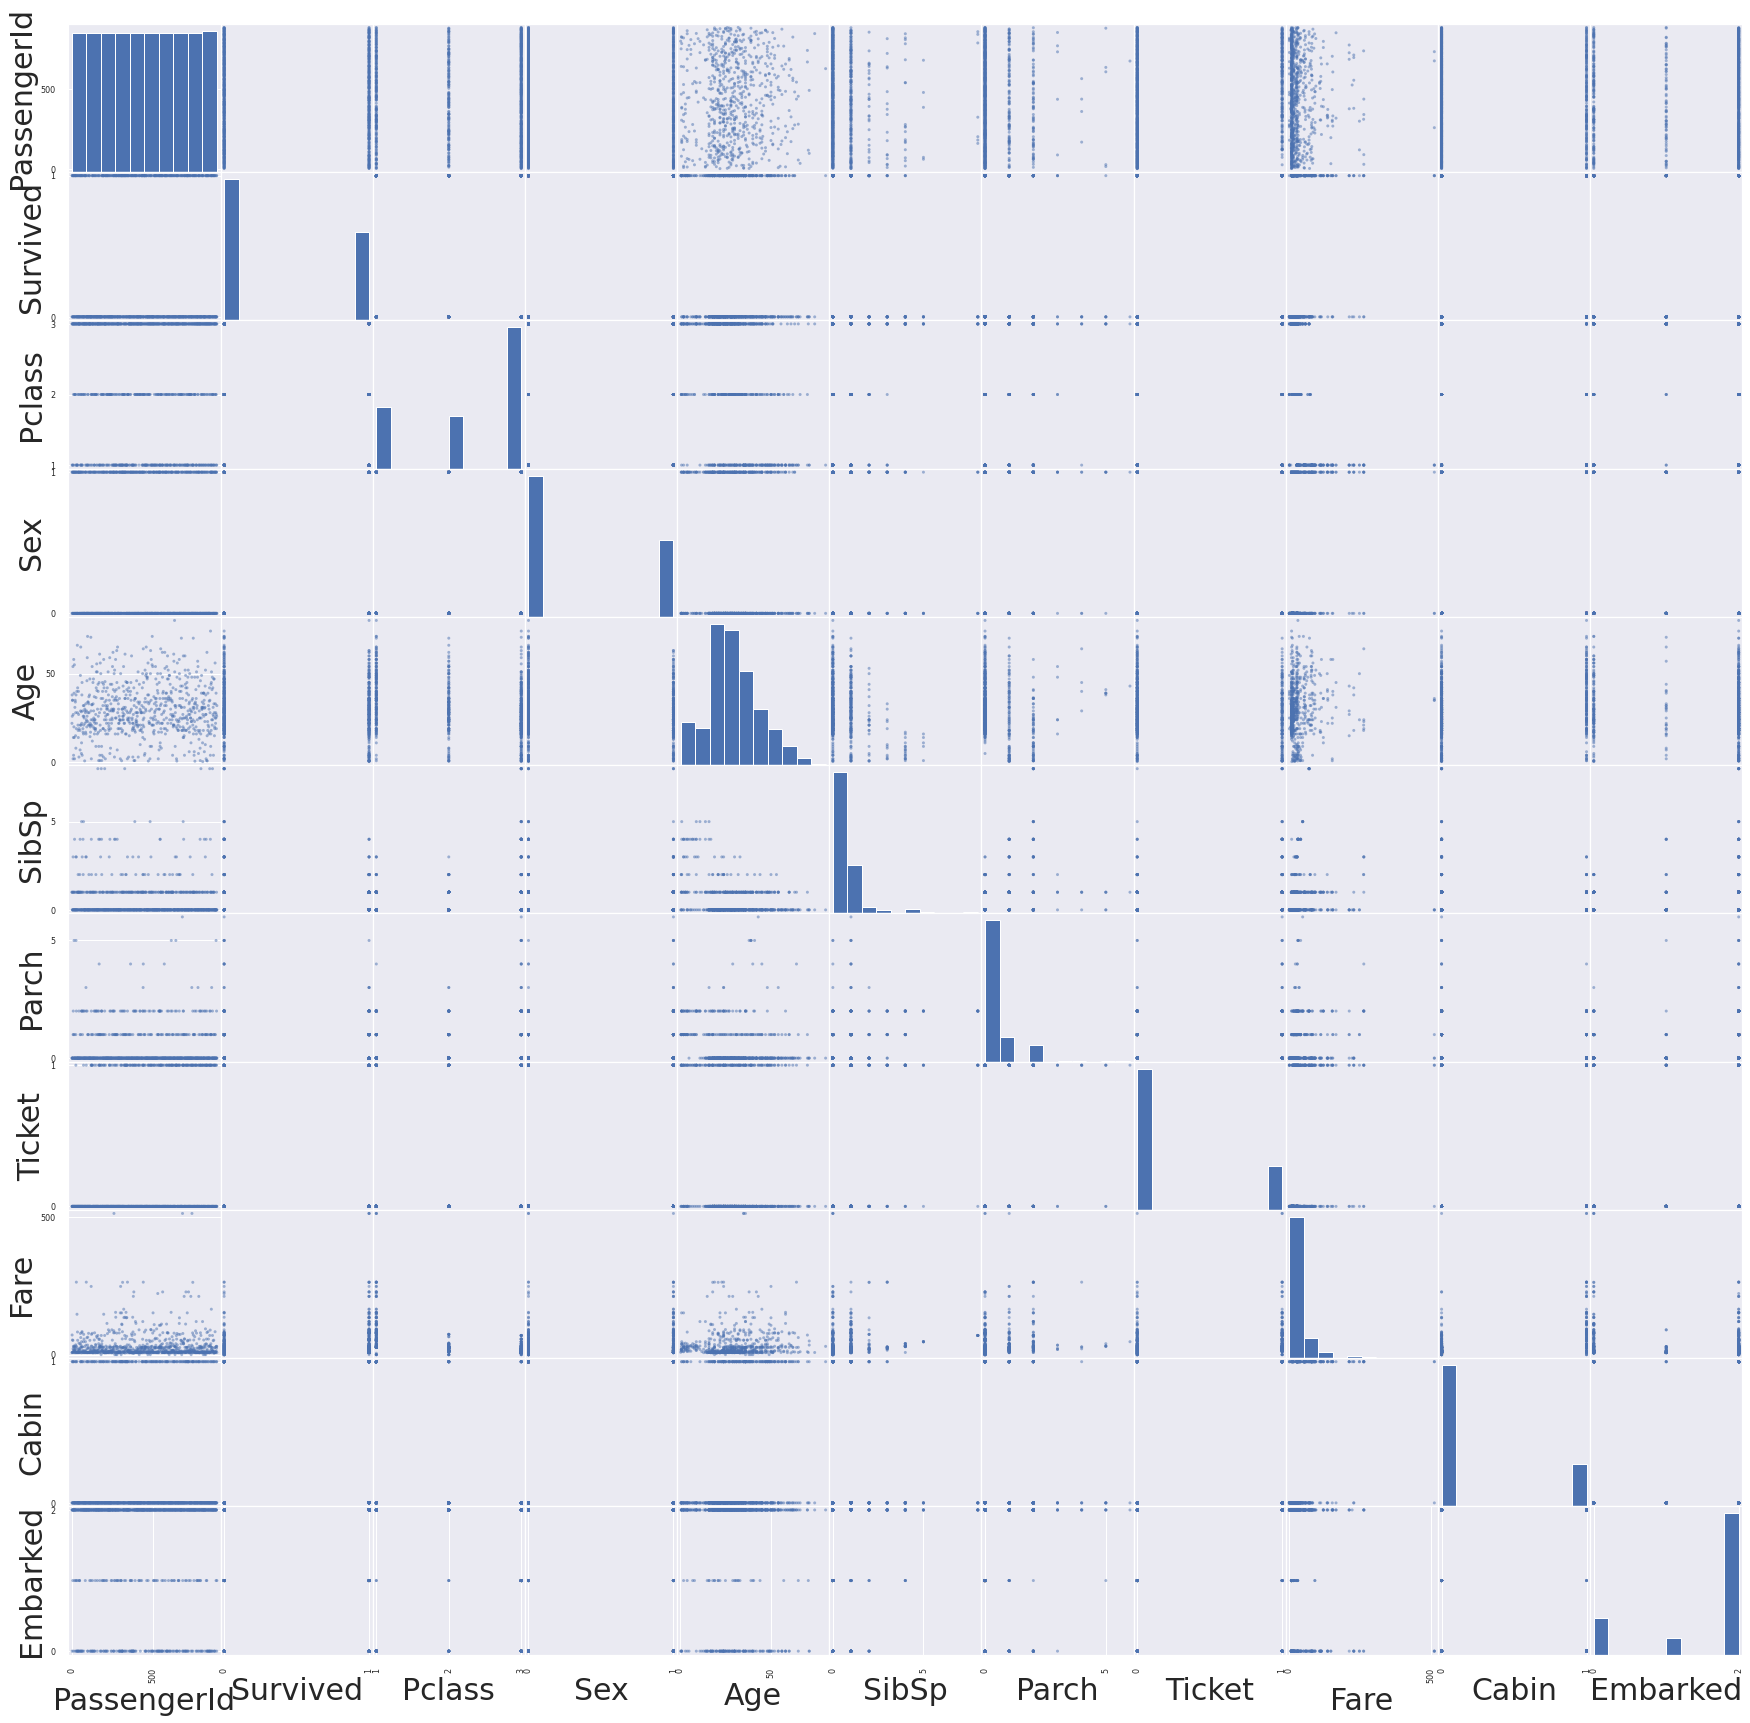

In [31]:
from pandas.plotting import scatter_matrix
scatter_matrix(train_filtered,figsize=(30,30))
plt.show()

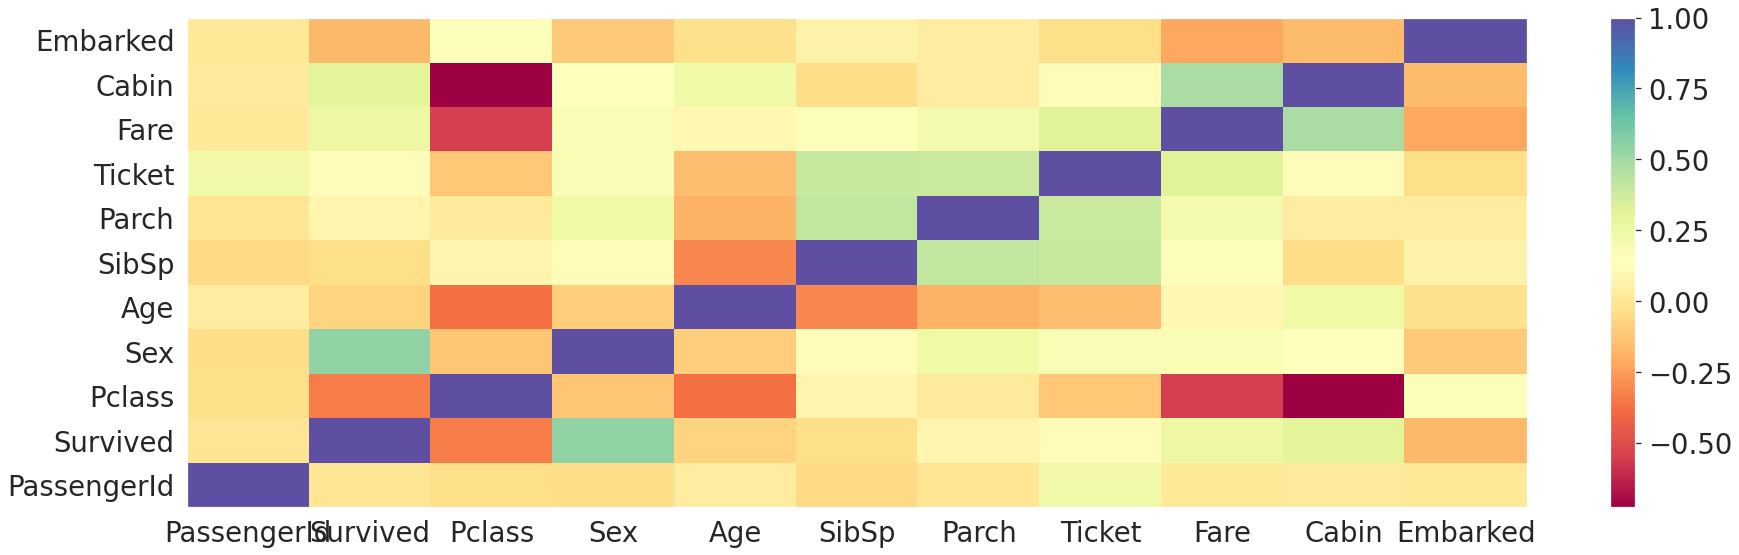

In [32]:
cor = train_filtered.corr()
plt.figure(figsize= (30,9))
plt.pcolor(cor, cmap='Spectral')
plt.yticks(np.arange(0.5, len(cor.index), 1), cor.index)
plt.xticks(np.arange(0.5, len(cor.columns), 1), cor.columns)
plt.colorbar()
plt.show()

* Survive 기준으로 봤을 때 두드러지게는
 Pclass, Sex, Embaked 가 유의미해 보인다.

####(3)각 속성별로 여러 시각화
구체적으로 관계를 파악 하기로 함

1) Pclass

2) Sex

3) Age

4) Embarked

5) Family - sibsp + parch 

6) Fare

7) ticket

순으로 파악

일일이 막대그래프를 만들지 않고 함수를 만들어서 사용하기로 함 
[출처](https://jfun.tistory.com/137?category=828812)

In [33]:
def bar_chart(feature):
    survived = train_copy[train_copy['Survived']==1][feature].value_counts()
    dead = train_copy[train_copy['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

#### Target lable 확인 

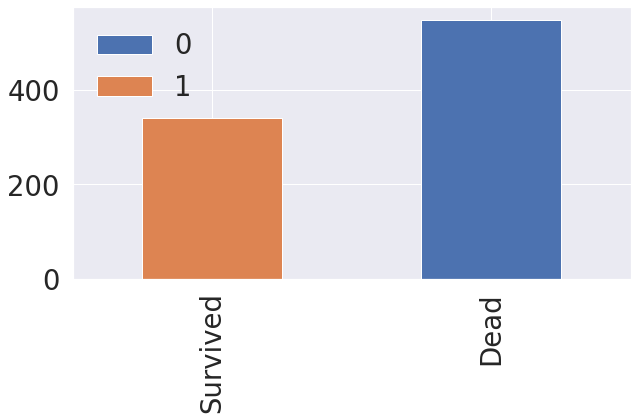

In [34]:
bar_chart('Survived')

* 분포 비교적 균등함-정확도가 편향되지 않을 것으로 예상

##**1) Pclass**

- Pclass는 앞서 .describe() 함수와 시각화한 
그래프에서 숫자형이지만 1,2,3의 범주를 갖고 있음을 알 수 있었다. 
- 따라서 class별 생존률을 확인해야함

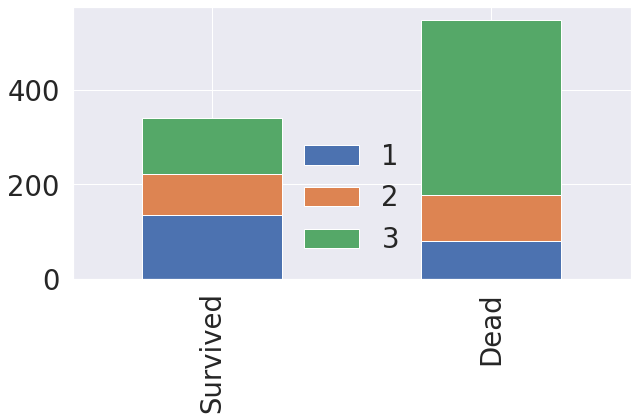

In [35]:
bar_chart('Pclass')

* 사망률이  3>2>1순으로 높다는 것을 알 수 있음

* pd.crosstab 사용하여 확인

In [36]:
pd.crosstab(train_copy['Pclass'],train_copy['Survived'], 
margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


* mean값으로 클래스별 생존률 얻음 
 ex) calss 1: 136/216 = 0.629

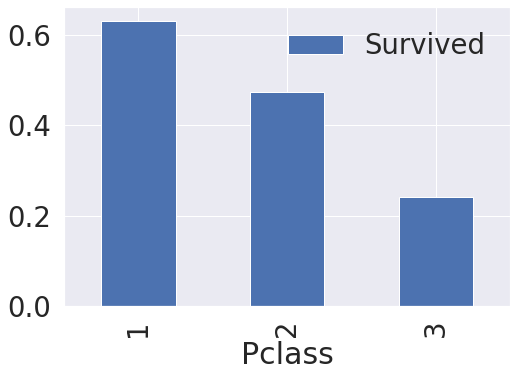

In [37]:
train_copy[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

* 막대 그래프와 마찬가지로 1>2>3순으로 생존률이 높다.
* 이 feature를 사용해야함

##**2) Sex**


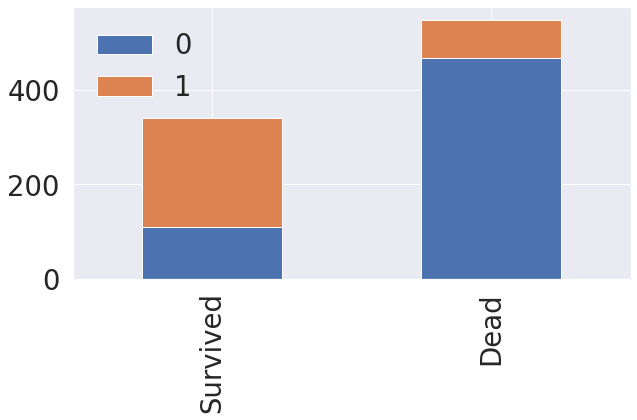

In [38]:
bar_chart('Sex')

* 남자가 확연히 더 많이 사망했음을 알 수 있다.
그래서 crosstab으로 확인은 생략한다.

  (찾아보니 lady first 풍습때문이라던데) 
* 이 feature도 중요함을 알 수 있다.

###**1) Pclass + 2) Sex**

- 중요한 이 feature들을 엮어보기로함

In [39]:
pd.crosstab([train_copy.Sex, train_copy.Survived], train_copy.Pclass,margins=True).style.background_gradient(cmap='summer_r') 
# 출처: https://crazyj.tistory.com/164 [크레이지J의 탐구생활]

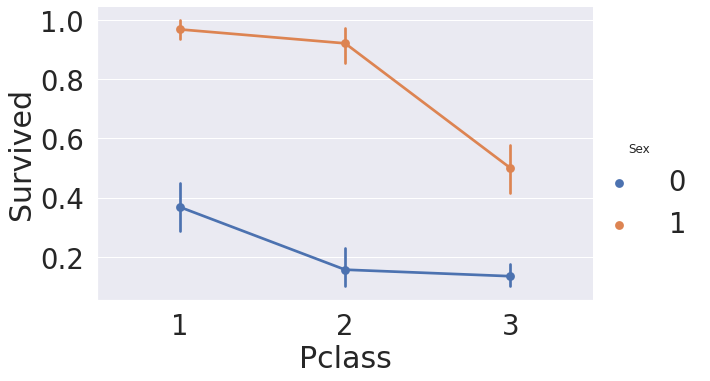

In [40]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=train_copy, size=6, aspect=1.5)

* 남녀 상관없이 1등급 객실일 수록 생존비율이 높고
* 객실에 상관없이 여성이 생존확률이 높다.
* 요약하면 1등급 여성이 가장 생존 확률이 높다.
(실제 타이타닉영화에 비춰보면 디카프리오가 생존확률이 가장 낮고 여자주인공이 가장 높다고 볼 수 있다.)

## **3) Age**
 Age 특성은 
 * 나이대가 다양하다. 
  >1. 나이대 별로 범주에 넣고 확인하거나 
  >2.**히스토그램**을 통해 확인할 수 있다.
  (히스토그램을 통해 확인해보고자 한다.)

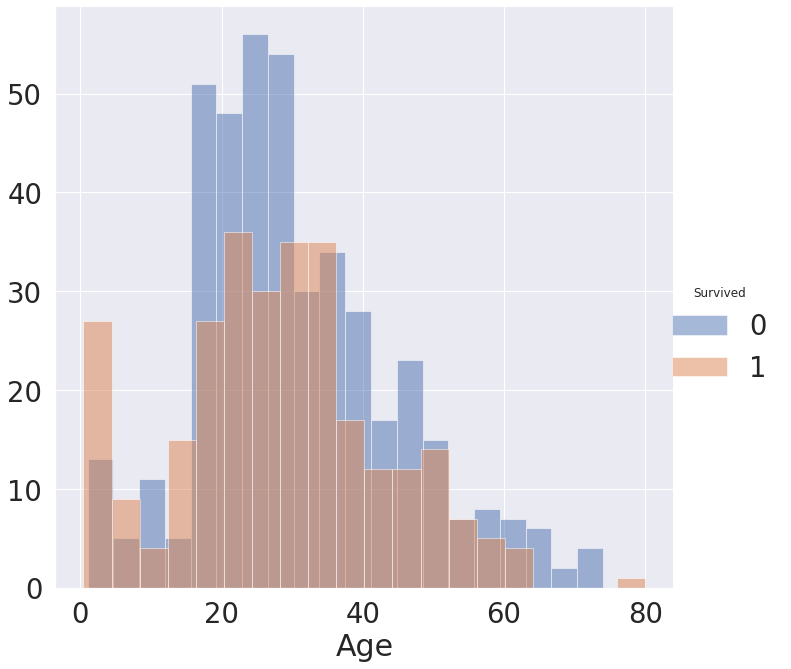

In [41]:
grid = sns.FacetGrid(train_copy, hue='Survived', size=10)
grid.map(plt.hist, 'Age', alpha=.5,bins=20)
grid.add_legend();
# https://right1203.tistory.com/entry/%EC%BA%90%EA%B8%80-%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89-%EC%83%9D%EC%A1%B4%EC%9E%90-%EC%98%88%EC%B8%A1

* 나이가 증가할 수록 사망했을 가능성이 더 크다는 것을 알 수 있다. 

결측치를 중위값으로 채운다.

In [42]:
train_copy['Age'].fillna(train_copy['Age'].median(), inplace = True)

## **4) Embarked**

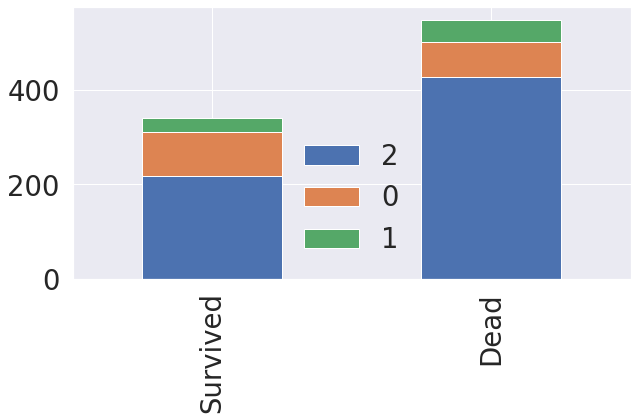

In [43]:
bar_chart('Embarked')

탑승한 항구의 위치와 부유한 사람들과 상관관계가 있는지 확인

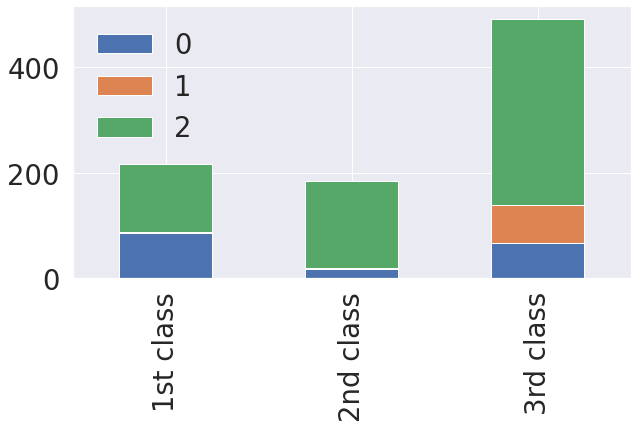

In [44]:
Pclass1 = train_copy[train_copy['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train_copy[train_copy['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train_copy[train_copy['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10,5))

클래스와 상관없이 S 항구에서 많이 탄 것을 알 수 있다. 따라서 결측치를 S로 채워주면 될 것 같다. 

In [45]:
train_copy['Embarked'].fillna(train_copy['Embarked'].mode()[0], inplace = True)

## **5) Family - sibsp + parch**

동승한 가족의 수에 따라 생존여부가 어떻게 되는지 파악해보고자한다.

In [46]:
train_copy['FamilySize'] = train_copy['SibSp'] + train_copy['Parch'] + 1

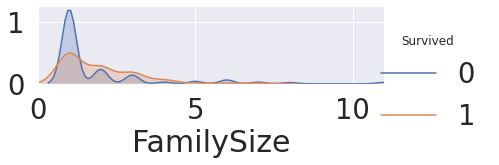

In [47]:
facet = sns.FacetGrid(train_copy, hue="Survived", aspect=2)
facet.map(sns.kdeplot, 'FamilySize', shade=True)
facet.set(xlim=(0, train_copy['FamilySize'].max()))
facet.add_legend()

혼자 탔을 경우 많이 죽었고 한명이라도 있을 경우 사망률이 상당히 감소했음을 알 수 있다.

##**6) Fare**


In [48]:
train_copy["Fare"].fillna(train_copy.groupby('Pclass')['Fare'].transform('median'), inplace=True)

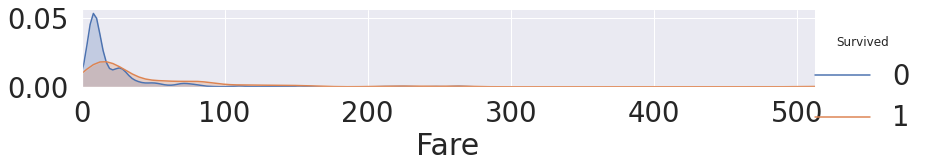

In [49]:
facet = sns.FacetGrid(train_copy, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, train_copy['Fare'].max()))
facet.add_legend()

plt.show()

싼 티켓을 구매한 사람은 사망률이 높고 비싼 티켓을 구매한 사람은 생존률이 높다

##**7) ticket**
- 티켓의 이름이므로 생략하기로 한다.

#4.  데이터 전처리 -Correction,Completing,Creating, Converting

(Correction;위에서 함)
,  Completing ,Creating, Converting


##COMPLETING :
#####학습, 테스트, 검증 데이터셋의 결측값들을 채워넣거나 삭제하기
[출처] [캐글 타이타닉] 3. 데이터 전처리 마무리|작성자 러닝머신





In [50]:
data_cleaner = [train_copy, test_set]

In [51]:
for dataset in data_cleaner:    
    #Age 결측치를 중위값으로 채우기
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #Embarked 결측치를 최빈값으로 채우기
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #Fare 결측치를 중위값으로 채우기 
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
#Cabin을 비롯해 앞서 삭제하기로 언급한 칼럼(피처)을 학습 데이터에서 삭제
drop_column = ['Cabin', 'Ticket']
dataset.drop(drop_column, axis=1, inplace = True)
print(train_copy.isnull().sum())
print("-"*10)
print(test_set.isnull().sum())



PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
FamilySize     0
dtype: int64
----------
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
FamilySize     0
dtype: int64


In [52]:
dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,3
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,8.0500,S,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,S,1
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,8.0500,S,1


##CREATING :
#####학습, 테스트, 검증 데이터셋에서 특징값 추출



In [53]:
for dataset in data_cleaner:    
   #이산적 변수들
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #혼자일 경우 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # 혼자가 아닐 경우, 즉 가족의 규모가 1보다 클 경우 혼자가 아님(0)으로 표시

    #name에서 title을 분리해 내는 빠르지만 지저분한 코드: http://www.pythonforbeginners.com/dictionary/python-split
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


    #연속형 변수 구간나누기(binning); qcut vs cut:https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    # Fare 변수 qcut으로 구간나누기, 혹은 빈도 구간으로 나누기 :  https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age 변수 cut 함수로 구간나누기 : : https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)



In [54]:
#희소한 직위 명 제거
#print(train_copy['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
#"작은 수"는 임의적이므로, 통계상 일반적으로 쓰이는 최소값을 사용함
title_names = (dataset['Title'].value_counts() < stat_min) #this will create a true false series with title name as index
#이 코드는 작위 명을 색인으로 하는 논리값 리스트를 뽑아냄

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
#apply와 lambda함수는 더 적은 코드로 원하는 기능을 수행할 수 있는 빠르고 더러운 코드임
dataset['Title'] = dataset['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(dataset['Title'].value_counts())
print("-"*10)



Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64
----------


In [55]:
#preview data again
#데이터 다시 둘러보기
train_copy.info()
test_set.info()
train_copy.sample(10)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    int64   
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    int64   
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    int64   
 11  Embarked     891 non-null    int64   
 12  FamilySize   891 non-null    int64   
 13  IsAlone      891 non-null    int64   
 14  Title        891 non-null    object  
 15  FareBin      891 non-null    category
 16  AgeBin       891 non-null    category
dtypes: category(2), float64(2), int64(11), object(2)
memory usage: 106.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",0,28.0,1,1,1,15.2458,0,0,3,0,Master,"(14.454, 31.0]","(16.0, 32.0]"
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",0,31.0,0,0,0,10.5000,0,2,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",0,20.0,0,0,0,7.9250,0,2,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",1,6.0,0,1,1,33.0000,0,2,2,0,Miss,"(31.0, 512.329]","(-0.08, 16.0]"
39,40,1,3,"Nicola-Yarred, Miss. Jamila",1,14.0,1,0,0,11.2417,0,0,2,0,Miss,"(7.91, 14.454]","(-0.08, 16.0]"
290,291,1,1,"Barber, Miss. Ellen ""Nellie""",1,26.0,0,0,0,78.8500,0,2,1,1,Miss,"(31.0, 512.329]","(16.0, 32.0]"
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",1,28.0,0,0,0,7.7500,0,1,1,1,Miss,"(-0.001, 7.91]","(16.0, 32.0]"
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",0,16.0,2,0,1,18.0000,0,2,3,0,Mr,"(14.454, 31.0]","(-0.08, 16.0]"
208,209,1,3,"Carr, Miss. Helen ""Ellen""",1,16.0,0,0,0,7.7500,0,1,1,1,Miss,"(-0.001, 7.91]","(-0.08, 16.0]"
136,137,1,1,"Newsom, Miss. Helen Monypeny",1,19.0,0,2,0,26.2833,1,2,3,0,Miss,"(14.454, 31.0]","(16.0, 32.0]"


##CONVERT :
#####대상을 Label Encoder를 이용해 범주로 변환시키기




In [56]:
#code categorical data
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])



##y변수(목표 변수)를 설정



In [57]:
Target = ['Survived']

#define x variables for original features aka feature selection
#x변수 설정하기. feature selection이라고도 한다.

train_copy_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
#pretty name/values for charts
#차트를 위해 이름/값을 예쁘게 만들어주기

train_copy_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
#coded for algorithm calculation
#알고리즘 계산을 위해 코드화 됨
train_copy_xy =  Target + train_copy_x
print('Original X Y: ', train_copy_xy, '\n')



Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 



##x변수 설정
####:연속형 변수들을 제거하기 위해 x 변수들을 정의



In [58]:
train_copy_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
train_copy_xy_bin = Target + train_copy_x_bin
print('Bin X Y: ', train_copy_xy_bin, '\n')



Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 



##더미 변수들을 위해 x와 y변수 정의

In [59]:
train_copy_dummy = pd.get_dummies(train_copy[train_copy_x])
train_copy_x_dummy = train_copy_dummy.columns.tolist()
train_copy_xy_dummy = Target + train_copy_x_dummy
print('Dummy X Y: ', train_copy_xy_dummy, '\n')



train_copy_dummy.head()
print(train_copy_x_dummy)



Dummy X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Title_Capt', 'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir', 'Title_the Countess'] 

['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Title_Capt', 'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir', 'Title_the Countess']


##정제된 데이터 재확인

In [60]:
print('Train columns with null values: \n', train_copy.isnull().sum())
print("-"*10)
print (train_copy.info())
print("-"*10)

print('Test/Validation columns with null values: \n', test_set.isnull().sum())
print("-"*10)
print (test_set.info())
print("-"*10)

train_set.describe(include = 'all')



Train columns with null values: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Name           891 non-null    object  
 4   Sex            891 non-null    int64   
 5   Age            891 non-null    float64 
 6   SibSp          891 non-null    int64   
 7   Parch    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Mannion, Miss. Margareth",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


##트레이닝/테스트 데이터를 분할

제시된 테스트 파일은 대회 제출을 위한 진짜 검증 데이터이다. 따라서 우리는 트레이닝 데이터를 2개(75/25)로 분할하기 위해, sklearn 함수를 사용할 것이다. 

이 작업은 과적합(overfitting)을 방지하는 데 중요하다.

-sklearn의 train_test_split 함수를 사용할 것이고, 나중에는 sklearn의 교차검정함수를 사용할 예정





In [61]:
#학습과 테스트 데이터를 기본값이 설정된 함수로 분할
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
#random_state -> seed 혹은 통제 무작위 수 생성기
from sklearn import model_selection
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(train_copy[train_copy_x_calc], train_copy[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(train_copy[train_copy_x_bin], train_copy[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(train_copy_dummy[train_copy_x_dummy], train_copy[Target], random_state = 0)


print("train_copy Shape: {}".format(train_copy.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

train_copy Shape: (891, 22)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,0,3,2,11,1,1,0
68,1,3,2,8,7,1,1
253,0,3,2,11,2,1,2
320,0,3,2,11,1,1,0
706,1,2,2,12,1,2,1


#머신러닝 알고리즘 선택과 시작


In [62]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost = AdaBoostClassifier(base_estimator=None,
                              learning_rate=1.0,
                              n_estimators=100)

adaBoost.fit(train1_x, train1_y)

y_pred = adaBoost.predict(test1_x)

from sklearn.metrics import accuracy_score

accuracy_score(test1_y, y_pred)

0.8251121076233184

In [63]:
#그리드 탐색으로 최적 파라미터값 찾기
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
n_estimators = [100,140,145,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_r = [0.1,1,0.01,0.5]

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
grid = GridSearchCV(AdaBoostClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(train1_x, train1_y) 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1, 0.01, 0.5],
                         'n_estimators': [100, 140, 145, 150, 160, 170, 175,
                                          180, 185]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [64]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8029850746268657
{'learning_rate': 0.1, 'n_estimators': 100}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)


In [65]:
adaBoost_grid = grid.best_estimator_
adaBoost_grid.score(train1_x, train1_y)
#좀 더 정확도가 높아졌다..

0.8203592814371258

In [73]:
adaBoost_grid.fit(train1_x, train1_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)

In [66]:
train1_x

,Sex_Code,Pclass,Embarked_Code,Title_Code,SibSp,Parch,Age,Fare
105,0,3,2,11,0,0,28.0,7.8958
68,1,3,2,8,4,2,17.0,7.9250
253,0,3,2,11,1,0,30.0,16.1000
320,0,3,2,11,0,0,22.0,7.2500
706,1,2,2,12,0,0,45.0,13.5000
...,...,...,...,...,...,...,...,...
835,1,1,0,8,1,1,39.0,83.1583
192,1,3,2,8,1,0,19.0,7.8542
629,0,3,1,11,0,0,28.0,7.7333
559,1,3,2,12,1,0,36.0,17.4000


In [67]:
test_set

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,1,1,Mr,"(-0.001, 7.896]","(30.4, 45.6]",1,1,3,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,2,0,Mrs,"(-0.001, 7.896]","(45.6, 60.8]",0,2,4,3,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,1,1,Mr,"(7.896, 14.454]","(60.8, 76.0]",1,1,3,4,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,1,1,Mr,"(7.896, 14.454]","(15.2, 30.4]",1,2,3,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,3,0,Mrs,"(7.896, 14.454]","(15.2, 30.4]",0,2,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,8.0500,S,1,1,Mr,"(7.896, 14.454]","(15.2, 30.4]",1,2,3,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C,1,1,Misc,"(31.472, 512.329]","(30.4, 45.6]",0,0,1,2,3
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,S,1,1,Mr,"(-0.001, 7.896]","(30.4, 45.6]",1,2,3,2,0
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,8.0500,S,1,1,Mr,"(7.896, 14.454]","(15.2, 30.4]",1,2,3,1,1


In [68]:
test_set_x = ['PassengerId','Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
test_set[test_set_x]

,PassengerId,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
0,892,1,3,1,3,1,2,0
1,893,0,3,2,4,2,3,0
2,894,1,2,1,3,1,4,1
3,895,1,3,2,3,1,1,1
4,896,0,3,2,4,3,1,1
...,...,...,...,...,...,...,...,...
413,1305,1,3,2,3,1,1,1
414,1306,0,1,0,1,1,2,3
415,1307,1,3,2,3,1,2,0
416,1308,1,3,2,3,1,1,1


In [74]:
output = adaBoost_grid.predict(test_set[test_set_x]).astype(int)

test_csv_df = pd.read_csv('/content/test.csv',low_memory=False)
df_output = pd.DataFrame()
df_output['PassengerId'] = test_csv_df['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('submission.csv', index=False)

In [76]:
output

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,